In [1]:
# Importo librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [2]:
np.random.seed(1992)

In [3]:
# Leo el archivo
data_frame = pd.read_csv('/content/dataset_1.csv')

In [4]:
device = ""
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

In [5]:
device

'cuda:0'

## **PUNTO 1**

In [7]:
# Renombro las columnas
data_frame = data_frame.rename(columns = {'# X': 'X'})

In [11]:
X_ = np.array(data_frame['X'])
y_ = np.array(data_frame['Y'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.30, random_state = 42)

In [13]:
# Defino mi función de costo MSE
def mse(y_truth, y_pred):
    cant = len(y_truth)
    r = np.sum([(y_truth[i] - y_pred[i])**2 for i in range(cant)])/cant
    return r

In [14]:
alpha = 0.0000001
n_epochs = 500
loss_train = []
loss_test = []

# Inicializo variables
w1, w2, b = np.random.uniform(0, 1, 3)

for epoch in range(n_epochs):

  ##################
  #### TRAINING ####
  ##################

  y_hat_acum = []

  X = X_train
  y = y_train

  # Inicializo variables
  #w1, w2, b = np.random.uniform(0, 1, 3)

  for i in range(len(X)):
        
      #FORWARD
      y_hat = w1 * X[i]**3 + w2 * X[i]**2 + w1 * X[i] + b

      #ERROR
      error = y[i] - y_hat

      #BACKPROPAGATION
      w1 = w1 - alpha * (-2 * error * (X[i]**3 + X[i]))
      w2 = w2 - alpha * (-2 * error * X[i]**2)
      b = b - alpha * (-2 * error)

  # ACUMULO LAS PREDICCIONES
  y_hat_acum = w1 * X**3 + w2 * X**2 + w1 * X + b

  #MSE
  loss_train.append(mse(y, y_hat_acum))

  ##################
  ### VALIDACIÓN ###
  ##################

  y_hat_acum = []

  X = X_test
  y = y_test
        
  # ACUMULO LAS PREDICCIONES
  y_hat_acum = w1 * X**3 + w2 * X**2 + w1 * X + b

  #MSE
  loss_test.append(mse(y, y_hat_acum))

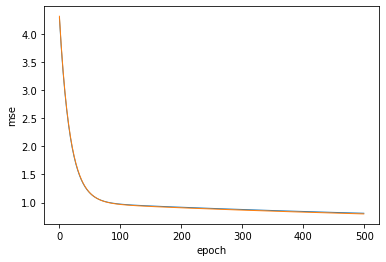

In [15]:
# Grafico el error en train y en test
epochs = np.arange(n_epochs)
plt.plot(epochs, loss_train, linewidth = 1)
plt.plot(epochs, loss_test, linewidth = 1)
plt.xlabel('epoch')
plt.ylabel('mse')
plt.show()

Acá vemos el error en entrenamiento (azul) en y en validación (naranja). Los errores dan muy parecidos y convergen a un valor cercano a cero, por lo que no hay indicios de overfitting.

In [16]:
# Calculo predicciones
preds = w1 * X_**3 + w2 * X_**2 + w1 * X_ + b

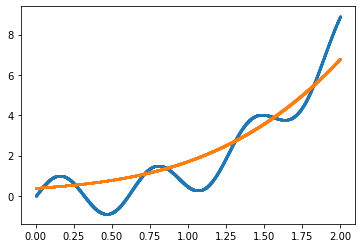

In [17]:
# Grafico la curva real y el modelo
plt.scatter(X_, y_, s = 1)
plt.scatter(X_, preds, s = 1)
plt.show()

El modelo propuesto no ajusta bien, es demasiado rígido.

## **PUNTO 2**

In [18]:
class MyDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [19]:
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

In [20]:
train_ds = MyDataset(X_train, y_train)
test_ds = MyDataset(X_test, y_test)

In [21]:
train_dataloader = DataLoader(train_ds, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_ds, batch_size = 64, shuffle = True)

In [22]:
class NNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features = 1, out_features = 1000, bias = True)
        self.sigmoid_1 = torch.nn.Sigmoid()
        self.linear_2 = torch.nn.Linear(in_features = 1000, out_features = 500, bias = True)
        self.sigmoid_2 = torch.nn.Sigmoid()
        self.linear_3 = torch.nn.Linear(in_features = 500, out_features = 300, bias = True)
        self.sigmoid_3 = torch.nn.Sigmoid()
        self.output = torch.nn.Linear(in_features = 300, out_features = 1, bias = True)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.sigmoid_1(x)
        x = self.linear_2(x)
        x = self.sigmoid_2(x)
        x = self.linear_3(x)
        x = self.sigmoid_3(x)
        x = self.output(x)
        return x

In [23]:
nnet = NNet()

In [24]:
loss_function = torch.nn.MSELoss(reduction = 'sum')

In [25]:
lr = 0.0005
ep = 800
optimizer = torch.optim.Adam(nnet.parameters(), lr = lr)

nnet.to(device)

loss_train = []
loss_test = []

train_loss_by_epoch = []
test_loss_by_epoch = []

for epoch in range(ep):

    ###################################################
    #### ENTRENAMIENTO
    ###################################################
    
    nnet.train(True)

    train_epoch_loss = 0
    
    for i, data in enumerate(train_dataloader):
        
        # obtener datos del batch
        X_batch, y_batch = data
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        
        # forward
        optimizer.zero_grad()
        nnet_output = nnet(X_batch)
        y_batch = y_batch.reshape(-1, 1)
        
        # backpropagation
        loss = loss_function(nnet_output, y_batch)
        loss.backward()
        
        # actualizo parámetros
        optimizer.step()

        # acumular el loss
        train_epoch_loss = train_epoch_loss + loss.item()

    # epoch_loss -> tengo acumulado el error de todo el dataset en un epoch
    train_loss_by_epoch.append(train_epoch_loss / len(train_ds))
        
    ###################################################
    #### VALIDACIÓN
    ###################################################

    nnet.train(False)

    test_epoch_loss = 0

    for i, data in enumerate(test_dataloader):

        # obtener los datos del batch
        X_batch, y_batch = data
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        nnet_output = nnet(X_batch)
        y_batch = y_batch.reshape(-1, 1)

        # compute loss
        loss = loss_function(nnet_output, y_batch)

        # acumular el loss
        test_epoch_loss = test_epoch_loss + loss.item() 

    # epoch_loss -> tengo acumulado el error de todo el dataset en un epoch
    test_loss_by_epoch.append(test_epoch_loss / len(test_ds))

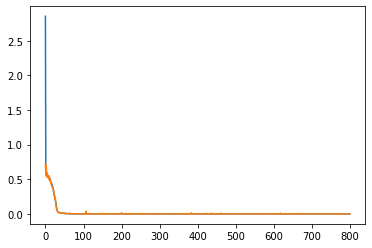

In [26]:
# Grafico el MSE en training y en test
x_epoch = np.arange(ep)
plt.plot(x_epoch, train_loss_by_epoch)
plt.plot(x_epoch, test_loss_by_epoch)
plt.show()

In [27]:
# Muestro los errores en train y test
print(train_loss_by_epoch[-1])
print(test_loss_by_epoch[-1])

4.448180238250643e-05
0.00012310619823013743


In [28]:
# Calculo predicciones
preds = nnet(torch.tensor(X_).to(device).float().reshape(-1,1))

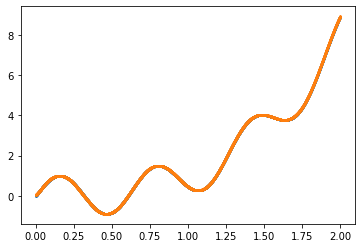

In [29]:
# Grafico la curva real y el modelo
plt.scatter(X_, y_, s = 1)
plt.scatter(X_, preds.cpu().detach().numpy(), s = 1)
plt.show()

Intenté, mediante una red de 3 capas ocultas con 1000, 500 y 300 neuronas respectivamente, sobreajustar el modelo, pero es imposible porque los datos fueron generados con una función que el modelo encontró perfectamente bien. Puedo determinar que no hay overfitting porque el error en train y en test son casi 0, y el error en test nunca se alejó ni subió en ningún momento, sino que convergió a cero junto con el error de entrenamiento.

Sin embargo, si no quiero un modelo que se ajuste tan bien a la curva, puedo rigidizarlo agregándole un término a la función de costo. El caso que está implementado en torch es la regresión Ridge (L2), y se setea con el parámetro weight_decay.

In [30]:
nnet = NNet()
loss_function = torch.nn.MSELoss(reduction = 'sum')

lr = 0.005
ep = 200
optimizer = torch.optim.Adam(nnet.parameters(), lr = lr, weight_decay = 0.05)

nnet.to(device)

loss_train = []
loss_test = []

train_loss_by_epoch = []
test_loss_by_epoch = []

for epoch in range(ep):

    ###################################################
    #### ENTRENAMIENTO
    ###################################################
    
    nnet.train(True)

    train_epoch_loss = 0
    
    for i, data in enumerate(train_dataloader):
        
        # obtener datos del batch
        X_batch, y_batch = data
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        
        # forward
        optimizer.zero_grad()
        nnet_output = nnet(X_batch)
        y_batch = y_batch.reshape(-1, 1)
        
        # backpropagation
        loss = loss_function(nnet_output, y_batch)
        loss.backward()
        
        # actualizo parámetros
        optimizer.step()

        # acumular el loss
        train_epoch_loss = train_epoch_loss + loss.item()

    # epoch_loss -> tengo acumulado el error de todo el dataset en un epoch
    train_loss_by_epoch.append(train_epoch_loss / len(train_ds))
        
    ###################################################
    #### VALIDACIÓN
    ###################################################

    nnet.train(False)

    test_epoch_loss = 0

    for i, data in enumerate(test_dataloader):

        # obtener los datos del batch
        X_batch, y_batch = data
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        nnet_output = nnet(X_batch)
        y_batch = y_batch.reshape(-1, 1)

        # compute loss
        loss = loss_function(nnet_output, y_batch)

        # acumular el loss
        test_epoch_loss = test_epoch_loss + loss.item() 

    # epoch_loss -> tengo acumulado el error de todo el dataset en un epoch
    test_loss_by_epoch.append(test_epoch_loss / len(test_ds))

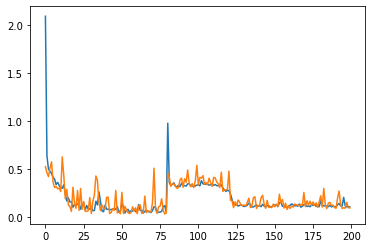

In [31]:
# Grafico el MSE en training y en test
x_epoch = np.arange(ep)
plt.plot(x_epoch, train_loss_by_epoch)
plt.plot(x_epoch, test_loss_by_epoch)
plt.show()

In [32]:
# Muestro los errores en train y test
print(train_loss_by_epoch[-1])
print(test_loss_by_epoch[-1])

0.10301957086154392
0.09317453519503276


In [33]:
# Calculo predicciones
preds = nnet(torch.tensor(X_).to(device).float().reshape(-1,1))

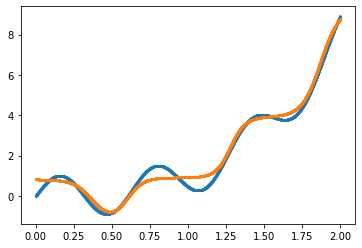

In [34]:
# Grafico la curva real y el modelo
plt.scatter(X_, y_, s = 1)
plt.scatter(X_, preds.cpu().detach().numpy(), s = 1)
plt.show()

Probé varios modelos agregando ruido al dataset para que le cueste más ajustar, pero al tomar tantos datos para el entrenamiento, el error agregado no le molesta al modelo, y sigue prediciendo muy bien. Por lo tanto, si quisiera lograr un sobreajuste con este dataset, se podría entrenar con pocos datos (por ejemplo el 10%), y testear en el 90% restante.

## **PUNTO 3**

In [190]:
data_frame2 = pd.read_csv('/content/dataset_2.csv')

In [191]:
def over_9000(x):
    if x >= 9000:
        r = 1
    else:
        r = 0
    return r    

In [192]:
data_frame2['Label'] = data_frame2['Purchase'].apply(over_9000)

In [193]:
data_frame2 = data_frame2.drop('Purchase', axis = 1)

In [194]:
len(np.unique(data_frame2['User_ID']))

5891

In [195]:
len(np.unique(data_frame2['Product_ID']))

3631

In [196]:
data_frame2

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Label
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,0
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,1
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,0
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,0
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
550063,1006033,P00372445,M,51-55,13,B,1,1,20,NaN,NaN,0
550064,1006035,P00375436,F,26-35,1,C,3,0,20,NaN,NaN,0
550065,1006036,P00375436,F,26-35,15,B,4+,1,20,NaN,NaN,0
550066,1006038,P00375436,F,55+,1,C,2,0,20,NaN,NaN,0


In [197]:
# Convierto las variables numéricas a catgóricas porque considero 
# que la categoría del producto no debería ser numérica.
data_frame2['Product_Category_2'] = data_frame2['Product_Category_2'].fillna(0).astype(int).astype(str)
data_frame2['Product_Category_3'] = data_frame2['Product_Category_3'].fillna(0).astype(int).astype(str)

In [198]:
# Chequeo que no haya NaNs.
data_frame2.isna().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Label                         0
dtype: int64

In [199]:
# Calculo los valores únicos de cada columna.
[len(np.unique(data_frame2.iloc[:,i])) for i in range(data_frame2.shape[1])]

[5891, 3631, 2, 7, 21, 3, 5, 2, 20, 18, 16, 2]

In [200]:
def str_to_num(x):
    if x == "4+":
        x = 4
    return x

In [201]:
# Convierto en variable numérica la columna.
data_frame2['Stay_In_Current_City_Years'] = data_frame2['Stay_In_Current_City_Years'].apply(str_to_num)    
data_frame2['Stay_In_Current_City_Years'] = data_frame2['Stay_In_Current_City_Years'].astype(int)

### a) Sin embeddings

In [202]:
# Apliqué OHE a las columnas
enc = OneHotEncoder(handle_unknown = 'ignore')

Opté por aplicar OHE a las columnas categóricas porque tengo muchos datos y asumí que no iba a predecir mal. De esta manera me queda un dataset de 68 columnas y más de 550 mil filas.

In [203]:
cols_to_OHE = ['Gender', 'Age', 'City_Category', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']
remain_cols = ['Occupation', 'Marital_Status']

In [204]:
X = enc.fit_transform(data_frame2[cols_to_OHE]).toarray()
X = np.hstack([X, data_frame2[remain_cols]])
X = pd.DataFrame(X, columns = np.concatenate((enc.get_feature_names(cols_to_OHE),remain_cols), axis = None))
X

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,City_Category_A,...,Product_Category_3_17,Product_Category_3_18,Product_Category_3_3,Product_Category_3_4,Product_Category_3_5,Product_Category_3_6,Product_Category_3_8,Product_Category_3_9,Occupation,Marital_Status
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550063,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0
550064,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
550065,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,1.0
550066,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [205]:
class MyDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [206]:
X = np.array(X)
y = np.array(data_frame2['Label'])

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [208]:
X_train = X_train.reshape(-1, 68)
X_test = X_test.reshape(-1, 68)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [209]:
train_ds = MyDataset(X_train, y_train)
test_ds = MyDataset(X_test, y_test)

In [210]:
train_dataloader = DataLoader(train_ds, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_ds, batch_size = 64, shuffle = True)

In [211]:
class NNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features = 68, out_features = 100, bias = True)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features = 100, out_features = 50, bias = True)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features = 50, out_features = 1, bias = True)
        self.output = torch.nn.Sigmoid()
   

    def forward(self, x):
        x = self.linear_1(x)
        x = self.relu_1(x)
        x = self.linear_2(x)
        x = self.relu_2(x)
        x = self.linear_3(x)
        x = self.output(x)
        return x

In [212]:
nnet = NNet()

loss_function = torch.nn.BCEWithLogitsLoss(reduction = "sum")

lr = 0.001
ep = 100
optimizer = torch.optim.Adam(nnet.parameters(), lr = lr)

nnet.to(device)

loss_train = []
loss_test = []

train_loss_by_epoch = []
test_loss_by_epoch = []

for epoch in range(ep):

    ###################################################
    #### ENTRENAMIENTO
    ###################################################
    
    nnet.train(True)

    train_epoch_loss = 0
    
    for i, data in enumerate(train_dataloader):
        
        # obtener datos del batch
        X_batch, y_batch = data
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        
        # forward
        optimizer.zero_grad()
        nnet_output = nnet(X_batch)
        y_batch = y_batch.reshape(-1, 1)
        
        # backpropagation
        loss = loss_function(nnet_output, y_batch)
        loss.backward()
        
        # actualizo parámetros
        optimizer.step()

        # acumular el loss
        train_epoch_loss = train_epoch_loss + loss.item()

    # epoch_loss -> tengo acumulado el error de todo el dataset en un epoch
    train_loss_by_epoch.append(train_epoch_loss / len(train_ds))
        
    ###################################################
    #### VALIDACIÓN
    ###################################################

    nnet.train(False)

    test_epoch_loss = 0
    acc = []

    for i, data in enumerate(test_dataloader):

        # obtener los datos del batch
        X_batch, y_batch = data
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        nnet_output = nnet(X_batch)
        y_batch = y_batch.reshape(-1, 1)

        # compute loss
        loss = loss_function(nnet_output, y_batch)

        # acumular el loss
        test_epoch_loss = test_epoch_loss + loss.item()
        
        # accuracy
        actual_acc = (y_batch == nnet_output).detach().cpu().numpy()
        acc = np.concatenate((acc, actual_acc), axis = None)
        
    accuracy = np.mean(acc)        

    # epoch_loss -> tengo acumulado el error de todo el dataset en un epoch
    test_loss_by_epoch.append(test_epoch_loss / len(test_ds))
    
    print(f"Epoch: {epoch} | Training loss: {train_epoch_loss / len(train_ds)} | Accuracy: {accuracy}")

Epoch: 0 | Training loss: 0.6126583944896177 | Accuracy: 6.059834808903109e-06
Epoch: 1 | Training loss: 0.6103164241239055 | Accuracy: 0.07248774398409899
Epoch: 2 | Training loss: 0.6100859007813729 | Accuracy: 0.16865126256658244
Epoch: 3 | Training loss: 0.6098899341619483 | Accuracy: 0.1931148156901243
Epoch: 4 | Training loss: 0.6097793557875612 | Accuracy: 0.2544403439562238
Epoch: 5 | Training loss: 0.6097131413357133 | Accuracy: 0.2172935565776477
Epoch: 6 | Training loss: 0.6096008403651573 | Accuracy: 0.24959853594391018
Epoch: 7 | Training loss: 0.6095578776402364 | Accuracy: 0.21230025269511152
Epoch: 8 | Training loss: 0.6094824498747295 | Accuracy: 0.23876961114040032
Epoch: 9 | Training loss: 0.6094332944178198 | Accuracy: 0.28628477587700957
Epoch: 10 | Training loss: 0.6093930863136462 | Accuracy: 0.25248301731294803
Epoch: 11 | Training loss: 0.6092995366605912 | Accuracy: 0.2587125274965004
Epoch: 12 | Training loss: 0.609261314173579 | Accuracy: 0.27397119154531846

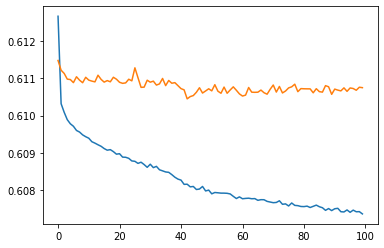

In [213]:
# Grafico el MSE en training y en test
x_epoch = np.arange(ep)
plt.plot(x_epoch, train_loss_by_epoch)
plt.plot(x_epoch, test_loss_by_epoch)
plt.show()

In [214]:
# Muestro los errores en train y test
print(train_loss_by_epoch[-1])
print(test_loss_by_epoch[-1])

0.6073665030563639
0.6107462895946588


### b) Con embeddings

In [215]:
# map user_id a user index 
unique = np.unique(data_frame2['User_ID'])
index = np.arange(0, len(unique))
user_id_to_index = {key:value for key, value in zip(unique, index)}
user_idx = np.array([user_id_to_index[i] for i in data_frame2['User_ID']])
user_idx

array([   0,    0,    0, ..., 5886, 5888, 5889])

In [216]:
# map product_id a product index 
unique = np.unique(data_frame2['Product_ID'])
index = np.arange(0, len(unique))
product_id_to_index = {key:value for key, value in zip(unique, index)}
product_idx = np.array([product_id_to_index[i] for i in data_frame2['Product_ID']])
product_idx

array([ 672, 2376,  852, ..., 3568, 3568, 3566])

In [217]:
class MyDatasetWithEmb(Dataset):

    def __init__(self, X, user_idx, product_idx, y):
        super().__init__()
        self.X = X
        self.user_idx = user_idx
        self.product_idx = product_idx
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.user_idx[idx], self.product_idx[idx], self.y[idx]

In [218]:
X = enc.fit_transform(data_frame2[cols_to_OHE]).toarray()
X = np.hstack([X, data_frame2[remain_cols]])
X = pd.DataFrame(X, columns = np.concatenate((enc.get_feature_names(cols_to_OHE),remain_cols), axis = None))
X = np.hstack([user_idx.reshape(-1,1), product_idx.reshape(-1,1), X])
X.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(550068, 70)

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)
user_index_train = X_train[:,0]
user_index_test = X_test[:,0]
product_index_train = X_train[:,1]
product_index_test = X_test[:,1]
X_train = X_train[:,np.arange(2,70)]
X_test = X_test[:,np.arange(2,70)]

In [220]:
train_ds = MyDatasetWithEmb(X_train, user_index_train, product_index_train, y_train)
test_ds = MyDatasetWithEmb(X_test, user_index_test, product_index_test, y_test)

In [221]:
train_dataloader = DataLoader(train_ds, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_ds, batch_size = 64, shuffle = True)

In [222]:
class NNetWithEmb(torch.nn.Module):

    def __init__(self, num_users, num_products, d):
        super().__init__()
        self.embedding_1 = torch.nn.Embedding(num_embeddings = num_users, embedding_dim = d)
        self.embedding_2 = torch.nn.Embedding(num_embeddings = num_products, embedding_dim = d)
        self.linear_1 = torch.nn.Linear(in_features = 68 + 2*d, out_features = 100, bias = True)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features = 100, out_features = 50, bias = True)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features = 50, out_features = 1, bias = True)
        self.output = torch.nn.Sigmoid()

    def forward(self, x, user_idx, product_idx):
        user_emb = self.embedding_1(user_idx)
        product_emb = self.embedding_2(product_idx)
        final_input = torch.cat([x, user_emb, product_emb], dim = 1)       
        x = self.linear_1(final_input)    
        x = self.relu_1(x)     
        x = self.linear_2(x)   
        x = self.relu_2(x)
        x = self.linear_3(x)
        x = self.output(x)     
        return x

In [223]:
user_n = int(len(np.unique(data_frame2['User_ID'])))
product_n = int(len(np.unique(data_frame2['Product_ID'])))
nnet = NNetWithEmb(user_n, product_n, 8)

loss_function = torch.nn.BCEWithLogitsLoss(reduction = "sum")

lr = 0.001
ep = 100
optimizer = torch.optim.Adam(nnet.parameters(), lr = lr)

nnet.to(device)

loss_train = []
loss_test = []

train_loss_by_epoch = []
test_loss_by_epoch = []

for epoch in range(ep):

    ###################################################
    #### ENTRENAMIENTO
    ###################################################
    
    nnet.train(True)

    train_epoch_loss = 0
    
    for i, data in enumerate(train_dataloader):
        
        # obtener datos del batch
        X_batch, user_batch, product_batch, y_batch = data
        
        X_batch = X_batch.to(device).float()
        user_batch = user_batch.to(device).long()
        product_batch = product_batch.to(device).long()
        y_batch = y_batch.to(device).float()
        
        # forward
        optimizer.zero_grad()
        nnet_output = nnet(X_batch, user_batch, product_batch)
        y_batch = y_batch.reshape(-1, 1)
        
        # backpropagation
        loss = loss_function(nnet_output, y_batch)
        loss.backward()
        
        # actualizo parámetros
        optimizer.step()

        # acumular el loss
        train_epoch_loss = train_epoch_loss + loss.item()

    # epoch_loss -> tengo acumulado el error de todo el dataset en un epoch
    train_loss_by_epoch.append(train_epoch_loss / len(train_ds))
        
    ###################################################
    #### VALIDACIÓN
    ###################################################

    nnet.train(False)

    test_epoch_loss = 0
    acc = []

    for i, data in enumerate(test_dataloader):

        # obtener los datos del batch
        X_batch, user_batch, product_batch, y_batch = data
        X_batch = X_batch.to(device).float()
        user_batch = user_batch.to(device).long()
        product_batch = product_batch.to(device).long()
        y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        nnet_output = nnet(X_batch, user_batch, product_batch)
        y_batch = y_batch.reshape(-1, 1)

        # compute loss
        loss = loss_function(nnet_output, y_batch)

        # acumular el loss
        test_epoch_loss = test_epoch_loss + loss.item()
        
        # accuracy
        actual_acc = np.mean((y_batch == nnet_output).detach().cpu().numpy())
        acc = np.concatenate((acc, actual_acc), axis = None)
        
    accuracy = np.mean(acc)        

    # epoch_loss -> tengo acumulado el error de todo el dataset en un epoch
    test_loss_by_epoch.append(test_epoch_loss / len(test_ds))
    
    print(f"Epoch: {epoch} | Training loss: {train_epoch_loss / len(train_ds)} | Accuracy: {accuracy}")

Epoch: 0 | Training loss: 0.6130749537899239 | Accuracy: 0.00044227413726250484
Epoch: 1 | Training loss: 0.6080878450070473 | Accuracy: 0.008775287133478627
Epoch: 2 | Training loss: 0.6046322507418673 | Accuracy: 0.08636713474883342
Epoch: 3 | Training loss: 0.6026173959347804 | Accuracy: 0.13018987912984184
Epoch: 4 | Training loss: 0.6010380747789802 | Accuracy: 0.1598126362129133
Epoch: 5 | Training loss: 0.5998193779001904 | Accuracy: 0.18549378434571004
Epoch: 6 | Training loss: 0.5987364395437388 | Accuracy: 0.20737831089302192
Epoch: 7 | Training loss: 0.5977830160180159 | Accuracy: 0.22002647377358237
Epoch: 8 | Training loss: 0.5969661185073853 | Accuracy: 0.30877545426588765
Epoch: 9 | Training loss: 0.5963725341610107 | Accuracy: 0.30569311481327965
Epoch: 10 | Training loss: 0.5959122064412706 | Accuracy: 0.3818745738123571
Epoch: 11 | Training loss: 0.5953958770606358 | Accuracy: 0.4307440901980185
Epoch: 12 | Training loss: 0.5949847496769466 | Accuracy: 0.4505070797288

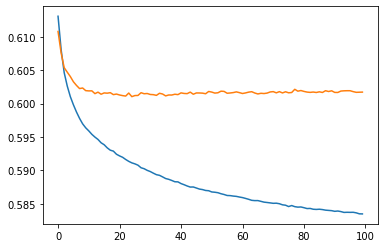

In [224]:
# Grafico el MSE en training y en test
x_epoch = np.arange(ep)
plt.plot(x_epoch, train_loss_by_epoch)
plt.plot(x_epoch, test_loss_by_epoch)
plt.show()

### c) Conclusiones

Se puede ver cómo en ambos modelos el error en training va decreciendo muy lentamente, mientras que el de test va convergiendo a un número fijo. Al ver este comportamiento en ambos modelos, me veo tentado a probar con más configuraciones de neuronas, más cantidad de épocas y diferentes learning rates. EN otras palabras, quiero decir que los modelos son mejorables, a juzgar por la curva de resultados que obtuve. Pero como el entrenamiento tomó mucho tiempo, me voy a quedar con lo que corrí, que en mi opinión es suficiente para sacar algunas conclusiones.

Olvidé de guardar en una lista el porcentaje de aciertos, por lo que luego de ejecutar las modeloes, guardé en un csv lo que imprimí en pantalla. No quise correrlo de nuevo porque demoró muchísimo. A continaución muestro esta comparación.

In [245]:
accuracy_dataset = pd.read_csv('/content/acc_ds.csv', delimiter = ';')

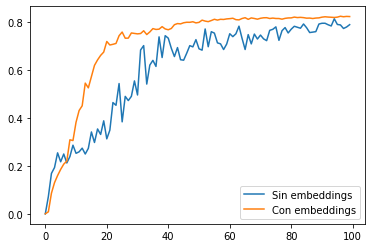

In [248]:
# Grafico el pocentaje de aciertos de ambos modelos, en función de las épocas.
x_epoch = np.arange(ep)
plt.plot(x_epoch, accuracy_dataset['sin_embeddings'].astype(float))
plt.plot(x_epoch, accuracy_dataset['con_embeddings'].astype(float))
plt.legend(['Sin embeddings', 'Con embeddings'])
plt.show()

NOTA: se utilizaron las mismas configuraciones para ambos modelos, para poder comprarlos. Esto es misma cantidad de capas ocultas y neuronas, mismas épocas y mismos learning rates. Lógicamente, la cantidad de parámetros no es la misma, puesto que el modelo de embeddings tiene muchos más.

La gráfica anterior muestra la precisión de mabos modelos en función de la cantidad de épocas. Podemos ver cómo el modelo con embeddings aprende mucho más rápido y luego baja su velocidad, pero se mantiene con una tendencia estrictamente creciente. Por otro lado, el modelo sin embeddings también muestra una tendencia creciente, pero a velocidad más lenta, además de que presenta mayor variabilidad. El resultao final fue mejor en el modelo con embeddings, alcanzando 82% vs 78%.

Estuve intentando extraer los vectores de embeddings finales para poder graficarlos en un plano XY y agruparlos a ver si notaba una lógica con los clústers. Pero tuve problemas para desacoplarlos del cuda, y me saltaron muchos errores. La idea era graficarlos en los ejes de sus dos componentes principales. Esperaba ver un agrupamiento de los datos correspondientes al label 1 y label 0 (los que gastaron más y menos de 9000), pero posiblemente podía sacar alguna conclusión más.

Intenté hacer lo siguiente para conseguir el vector de embeddings:
nnet.embeddings_1(torch.LongTensor([np.arange(0, user_n)]).cuda())

pero arrojaba un error.
Por favor, si pueden darme una observación acá y decir cómo conseguir el embedding fiteado, sería genial, porque el tema me encantó y quiero seguir trabajando con este tema.

## **PUNTO 4 (ítem d)**

Los ítems a, b y c están adjuntos en el github.

In [225]:
# Creo la función
def func(a, b, c):
    res = a * torch.log(b) + b * c ** 2
    return res

In [226]:
# Creo los tensores con los valores iniciales
a = torch.tensor([2.], requires_grad = True)
b = torch.tensor([10.], requires_grad = True)
c = torch.tensor([0.5], requires_grad = True)

In [227]:
# Hago la pasada forward
f = func(a, b, c)
f

tensor([7.1052], grad_fn=<AddBackward0>)

In [228]:
# Hago al pasada backward y muestro las derivadas
f.backward()
grad_a = a.grad
grad_b = b.grad
grad_c = c.grad

print("Gradiente df/da = " + str(grad_a))
print("Gradiente df/db = " + str(grad_b))
print("Gradiente df/dc = " + str(grad_c))

Gradiente df/da = tensor([2.3026])
Gradiente df/db = tensor([0.4500])
Gradiente df/dc = tensor([10.])
